In [245]:
import pickle
import os
import re
from utils_wiki import get_category_data
from utils_network import filter_graph_by_attribute, count_nodes_by_attribute
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

DOWNLOADS_DIR = "downloads"
RANDOM_STATE = 42
# Load the graph
S_undirected = pickle.load(open("pickle_files/graph_undirected.pkl", "rb"))
print(f"Nodes: {S_undirected.number_of_nodes()}, Edges: {S_undirected.number_of_edges()}")


Nodes: 1362, Edges: 8895


# Tradition communities

In [246]:
philosopher_tradition_info = pickle.load(open("pickle_files/philosopher_tradition_info.pkl", "rb"))

S_tradition = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_tradition_info,
    attribute_name='tradition',
    verbose=True
)

print("-"*50)
count_nodes_by_attribute(S_tradition, 'tradition', verbose=True)
print("-"*50)

Did not find tradition for: 1016 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Johann_Augustus_Eberhard', 'Judah_Leon_Abravanel', 'William_of_Moerbeke']
Original graph: 1362 nodes and 8895 edges
Filtered 'tradition' graph: 346 nodes and 2565 edges
--------------------------------------------------
Number of nodes by tradition:
 -> Western philosophers: 279
 -> Eastern philosophers: 69
--------------------------------------------------


## First: Check full filtered network statistics

### Anyone important missing?

In [247]:
# Get degrees for all nodes in the original graph
degree_dict = dict(S_undirected.degree())

# Check if each node is in the filtered graph
presence = {node: (node in S_tradition) for node in S_undirected.nodes()}

# Combine degree, presence, and tradition information
degree_data = [
    {
        'node': node,
        'degree': degree,
        'present': presence[node],
        'tradition': S_tradition.nodes[node]['tradition'] if presence[node] else None
    }
    for node, degree in degree_dict.items()
]

# Sort nodes by degree in descending order
degree_data = sorted(degree_data, key=lambda x: x['degree'], reverse=True)

# Assign colors based on tradition
def assign_color(entry):
    if not entry['present']:
        return 'red'
    tradition = entry['tradition']
    if tradition and 'Western philosophers' in tradition:
        return 'blue'
    elif tradition and 'Eastern philosophers' in tradition:
        return 'green'
    return 'gray'  # Default color if tradition is undefined

colors = [assign_color(entry) for entry in degree_data]

# Separate data for plotting
nodes = [entry['node'] for entry in degree_data]
degrees = [entry['degree'] for entry in degree_data]

# Create an interactive bar plot using Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=list(range(len(nodes))),
            y=degrees,
            marker_color=colors,
            text=[f"Node: {entry['node']}\nTradition: {entry['tradition']}" for entry in degree_data],
            hovertemplate="<b>%{text}</b><br><b>Degree:</b> %{y}<extra></extra>",
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Node Degrees in Original Graph (Color-coded by Tradition)",
    xaxis_title="Nodes (sorted by degree)",
    yaxis_title="Degree",
    hovermode="x",
    plot_bgcolor="white",
)

fig.show()


In [248]:
# Get content length for all nodes in the filtered graph
contentlength_dict = {
    node: S_tradition.nodes[node]['contentlength'] if node in S_tradition else None
    for node in S_undirected.nodes()
}

# Check if each node is in the filtered graph
presence = {node: (node in S_tradition) for node in S_undirected.nodes()}

# Combine content length, presence, and tradition information
contentlength_data = [
    {
        'node': node,
        'contentlength': contentlength_dict[node],
        'present': presence[node],
        'tradition': S_tradition.nodes[node]['tradition'] if presence[node] else None
    }
    for node in S_undirected.nodes()
]

# Filter out nodes without content length values (for non-present nodes)
contentlength_data = [entry for entry in contentlength_data if entry['contentlength'] is not None]

# Sort nodes by content length in descending order
contentlength_data = sorted(contentlength_data, key=lambda x: x['contentlength'], reverse=True)

# Assign colors based on tradition
def assign_color(entry):
    if not entry['present']:
        return 'red'
    tradition = entry['tradition']
    if tradition and 'Western philosophers' in tradition:
        return 'blue'
    elif tradition and 'Eastern philosophers' in tradition:
        return 'green'
    return 'gray'  # Default color if tradition is undefined

colors = [assign_color(entry) for entry in contentlength_data]

# Separate data for plotting
nodes = [entry['node'] for entry in contentlength_data]
contentlengths = [entry['contentlength'] for entry in contentlength_data]

# Create an interactive bar plot using Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=list(range(len(nodes))),
            y=contentlengths,
            marker_color=colors,
            text=[f"Node: {entry['node']}\nTradition: {entry['tradition']}" for entry in contentlength_data],
            hovertemplate="<b>%{text}</b><br><b>Content Length:</b> %{y}<extra></extra>",
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Node Content Length in Filtered Graph (Color-coded by Tradition)",
    xaxis_title="Nodes (sorted by content length)",
    yaxis_title="Content Length",
    hovermode="x",
    plot_bgcolor="white",
)

fig.show()

In [249]:
# Get degrees for all nodes in the original graph
degree_dict = dict(S_undirected.degree())

# Check if each node is in the filtered graph
presence = {node: (node in S_tradition) for node in S_undirected.nodes()}

# Combine degree and presence information
degree_data = [
    {'node': node, 'degree': degree, 'present': presence[node]}
    for node, degree in degree_dict.items()
]

# Sort nodes by degree in descending order
degree_data = sorted(degree_data, key=lambda x: x['degree'], reverse=True)

# Separate data for plotting
nodes = [entry['node'] for entry in degree_data]
degrees = [entry['degree'] for entry in degree_data]
colors = ['blue' if entry['present'] else 'red' for entry in degree_data]

# Create an interactive bar plot using Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=list(range(len(nodes))),
            y=degrees,
            marker_color=colors,
            text=nodes,  # Hover text
            hovertemplate="<b>Node:</b> %{text}<br><b>Degree:</b> %{y}<extra></extra>",
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Node Degrees in Original Graph (Red: Missing in Filtered Graph)",
    xaxis_title="Nodes (sorted by degree)",
    yaxis_title="Degree",
    hovermode="x",
    plot_bgcolor="white",
)

fig.show()


In [250]:
# print top nodes not present in the tradition graph
print("Most important philosophers not present in the tradition graph:")
for entry in degree_data[:1000]:
    if not entry['present']:
        print(entry['node'], entry['degree'])

Most important philosophers not present in the tradition graph:
Albert_Einstein 66
Vladimir_Lenin 54
Avicenna 47
Homer 46
John_Milton 46
Paul_Feyerabend 43
Francis_Bacon 42
Simplicius_of_Cilicia 42
Ernst_Laas 39
Leo_Tolstoy 38
Mircea_Eliade 34
Alexander_Zinoviev 34
Wilhelm_Wundt 34
John_Henry_Newman 33
Jean_Bodin 33
Galen 33
Richard_Price 31
Leon_Trotsky 31
Joseph_Priestley 30
John_McDowell 29
Paul_Tillich 29
Lucian 28
Hermann_Lotze 28
Alexandre_Kojève 27
David_Hilbert 27
Victor_Cousin 26
Benjamin_Franklin 26
Jean_Wahl 26
Albertus_Magnus 26
Samuel_Clarke 25
Johann_Gottfried_Herder 25
Georg_Cantor 25
Rudolf_Otto 24
Kuno_Fischer 24
Miguel_Abensour 24
Vladimir_Solovyov_(philosopher) 24
Novalis 24
Franz_Kafka 23
Iris_Murdoch 22
William_Blake 22
Christiaan_Huygens 22
Joseph_Butler 22
Edward_Gibbon 22
William_Whewell 22
Jean-François_Lyotard 22
William_Hazlitt 22
Benjamin_Fondane 22
Lev_Shestov 21
Ralph_Cudworth 21
Alexander_of_Aphrodisias 21
Cornelius_Castoriadis 21
Emil_Cioran 21
Charles_H

### Remove free nodes

In [251]:
# remove nodes that are not connected to the main component
largest_component = max(nx.connected_components(S_tradition), key=len)
#print nodes that are not in the largest component
for node in S_tradition.nodes:
    if node not in largest_component:
        print("Node not in largest component: ", node)
        print("Node attributes: ", S_tradition.nodes[node])


S_tradition = S_tradition.subgraph(largest_component).copy()
print("tradition graph after removing unconnected nodes: ", S_tradition)
print("-"*50)
count_nodes_by_attribute(S_tradition, 'tradition', verbose=True)
print("-"*50)

Node not in largest component:  Yajnavalkya
Node attributes:  {'contentlength': 3978, 'tradition': ['Eastern philosophers']}
tradition graph after removing unconnected nodes:  Graph with 345 nodes and 2565 edges
--------------------------------------------------
Number of nodes by tradition:
 -> Western philosophers: 279
 -> Eastern philosophers: 68
--------------------------------------------------


### Fit degree distribution to traditions graph

In [252]:
import pickle
import numpy as np
import networkx as nx
from scipy.stats import poisson, expon, lognorm
import powerlaw
import warnings

# Ignore warnings from powerlaw package
warnings.filterwarnings("ignore")

# Step 2: Extract the degree sequence
degrees = np.array([d for n, d in S_tradition.degree()])
print(f"Minimum degree: {np.min(degrees)}")
print(f"Maximum degree: {np.max(degrees)}")

# Step 3: Fit candidate distributions using MLE

# 3a. Poisson Distribution
lambda_poisson = np.mean(degrees)
log_likelihood_poisson = np.sum(poisson.logpmf(degrees, lambda_poisson))

# 3b. Exponential Distribution (continuous approximation)
params_exp = expon.fit(degrees, floc=0)  # Fix loc=0
lambda_exp = 1 / params_exp[1]  # Scale parameter is 1/lambda
log_likelihood_exp = np.sum(expon.logpdf(degrees, *params_exp))

# 3c. Log-Normal Distribution
params_lognorm = lognorm.fit(degrees[degrees > 0], floc=0)  # Exclude zeros
sigma_lognorm, loc_lognorm, scale_lognorm = params_lognorm
log_likelihood_lognorm = np.sum(lognorm.logpdf(degrees[degrees > 0], *params_lognorm))

# 3d. Power-Law Distribution
fit = powerlaw.Fit(degrees, xmin=1)
alpha_powerlaw = fit.power_law.alpha
xmin_powerlaw = fit.power_law.xmin
log_likelihood_powerlaw = fit.power_law.loglikelihoods(degrees).sum()

# Step 4: Compute AIC and BIC for each model
n = len(degrees)

# Poisson
k_poisson = 1  # lambda
AIC_poisson = 2 * k_poisson - 2 * log_likelihood_poisson
BIC_poisson = k_poisson * np.log(n) - 2 * log_likelihood_poisson

# Exponential
k_exp = 1  # lambda
AIC_exp = 2 * k_exp - 2 * log_likelihood_exp
BIC_exp = k_exp * np.log(n) - 2 * log_likelihood_exp

# Log-Normal
n_lognorm = len(degrees[degrees > 0])
k_lognorm = 2  # sigma and scale
AIC_lognorm = 2 * k_lognorm - 2 * log_likelihood_lognorm
BIC_lognorm = k_lognorm * np.log(n_lognorm) - 2 * log_likelihood_lognorm

# Power-Law
n_powerlaw = len(degrees[degrees >= xmin_powerlaw])
k_powerlaw = 2  # alpha and xmin
AIC_powerlaw = 2 * k_powerlaw - 2 * log_likelihood_powerlaw
BIC_powerlaw = k_powerlaw * np.log(n_powerlaw) - 2 * log_likelihood_powerlaw

# Step 5: Select the best-fitting model based on AIC and BIC
AICs = {
    'Poisson': AIC_poisson,
    'Exponential': AIC_exp,
    'Log-Normal': AIC_lognorm,
    'Power-Law': AIC_powerlaw
}

BICs = {
    'Poisson': BIC_poisson,
    'Exponential': BIC_exp,
    'Log-Normal': BIC_lognorm,
    'Power-Law': BIC_powerlaw
}

best_fit_aic = min(AICs, key=AICs.get)
best_fit_bic = min(BICs, key=BICs.get)

# Output results
print("\nModel fitting results:")
print("-----------------------")
print("Log-Likelihoods:")
print(f"Poisson: {log_likelihood_poisson}")
print(f"Exponential: {log_likelihood_exp}")
print(f"Log-Normal: {log_likelihood_lognorm}")
print(f"Power-Law: {log_likelihood_powerlaw}\n")

print("AIC values:")
for dist, aic in AICs.items():
    print(f"{dist}: {aic}")
print(f"Best fit according to AIC: {best_fit_aic}\n")

print("BIC values:")
for dist, bic in BICs.items():
    print(f"{dist}: {bic}")
print(f"Best fit according to BIC: {best_fit_bic}\n")

print("Estimated parameters:")
print("---------------------")
print(f"Poisson lambda: {lambda_poisson}")
print(f"Exponential lambda: {lambda_exp}")
print(f"Log-Normal sigma: {sigma_lognorm}, scale: {scale_lognorm}")
print(f"Power-Law alpha: {alpha_powerlaw}, xmin: {xmin_powerlaw}")

Minimum degree: 1
Maximum degree: 108

Model fitting results:
-----------------------
Log-Likelihoods:
Poisson: -2492.8028923242455
Exponential: -1276.2641997910423
Log-Normal: -1267.8842504187935
Power-Law: -1429.2871106488924

AIC values:
Poisson: 4987.605784648491
Exponential: 2554.5283995820846
Log-Normal: 2539.768500837587
Power-Law: 2862.574221297785
Best fit according to AIC: Log-Normal

BIC values:
Poisson: 4991.449329065523
Exponential: 2558.371943999116
Log-Normal: 2547.4555896716497
Power-Law: 2870.2613101318475
Best fit according to BIC: Log-Normal

Estimated parameters:
---------------------
Poisson lambda: 14.869565217391305
Exponential lambda: 0.06725146198830409
Log-Normal sigma: 0.9504201055852057, scale: 10.04363856351123
Power-Law alpha: 1.4334747484107968, xmin: 1.0


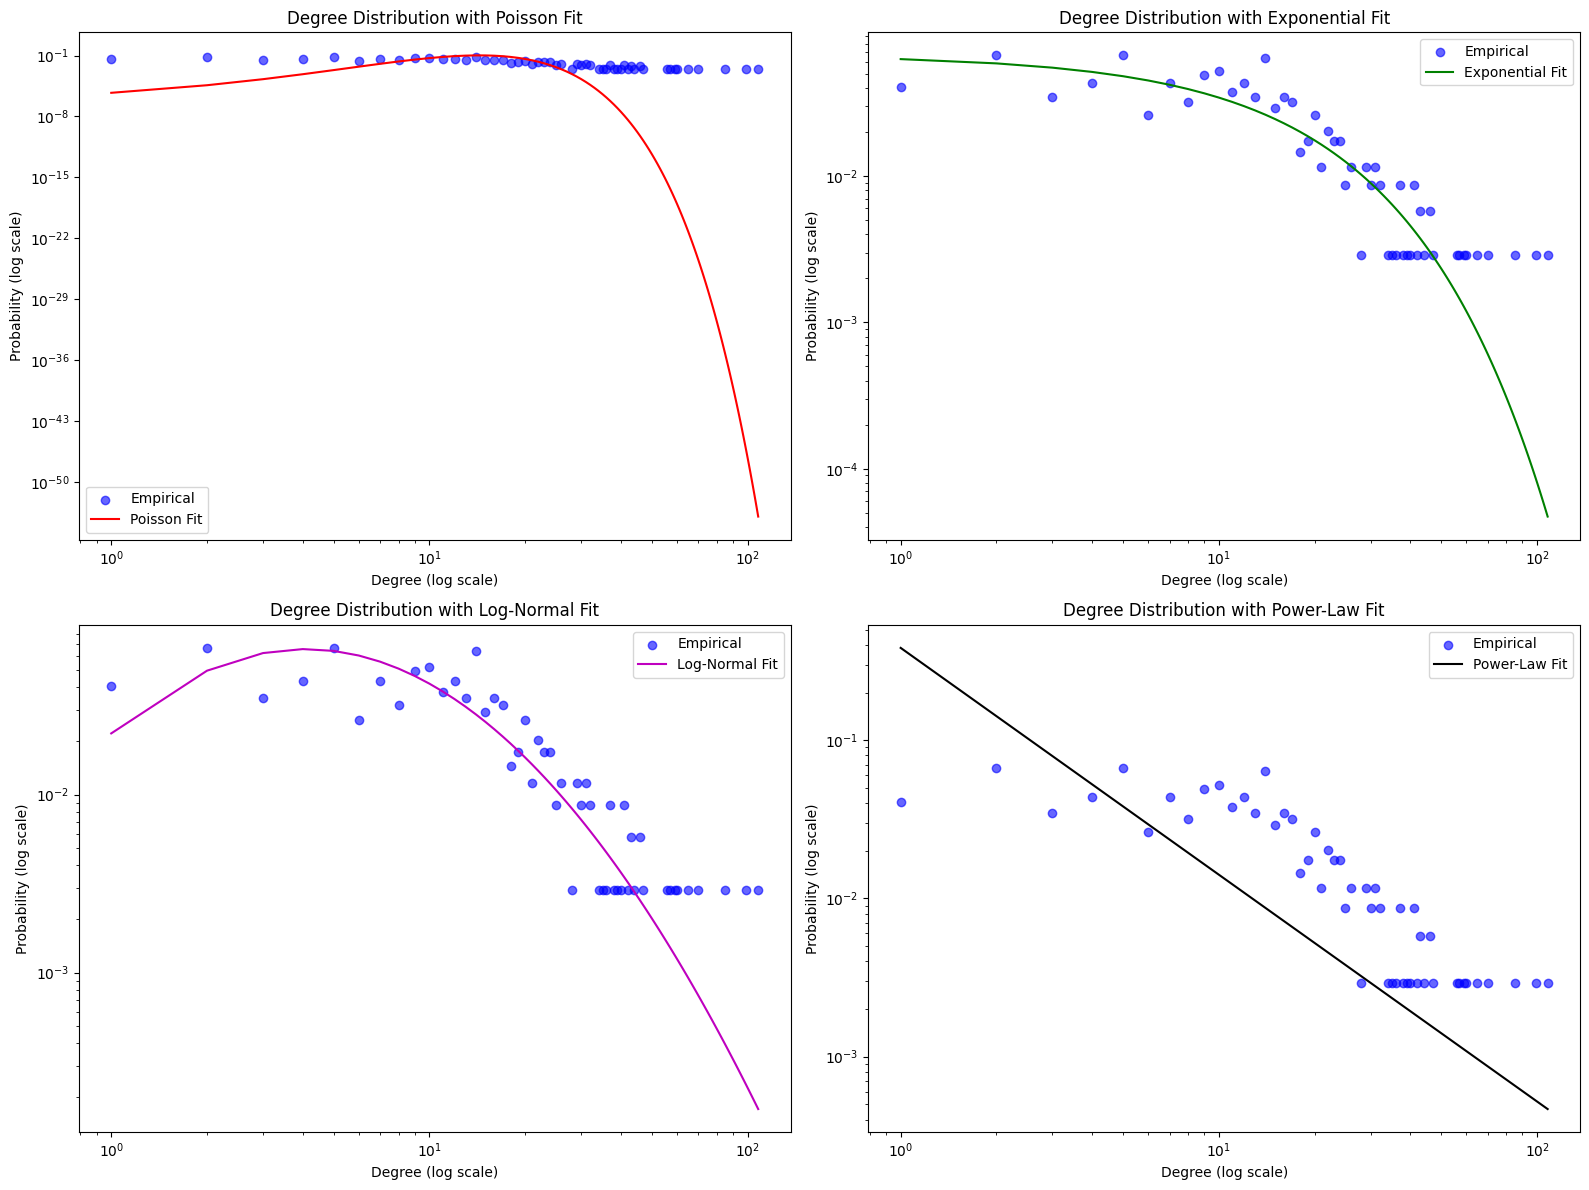

In [253]:
def plot_all_models_loglog(degrees, fitted_models):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    models = ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']
    colors = ['r', 'g', 'm', 'k']
    
    for ax, model, color in zip(axes.flatten(), models, colors):
        # Empirical degree distribution
        degree_counts = np.bincount(degrees)
        degrees_unique = np.nonzero(degree_counts)[0]
        counts = degree_counts[degrees_unique]
        prob = counts / counts.sum()
        
        ax.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
        
        # Generate degrees for plotting fitted model
        x = np.arange(degrees_unique.min(), degrees_unique.max()+1)
        
        if model == 'Poisson':
            pmf = poisson.pmf(x, fitted_models['Poisson']['lambda'])
            ax.plot(x, pmf, color=color, linestyle='-', label='Poisson Fit')
        elif model == 'Exponential':
            pdf = expon.pdf(x, scale=fitted_models['Exponential']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Exponential Fit')
        elif model == 'Log-Normal':
            pdf = lognorm.pdf(x, fitted_models['Log-Normal']['sigma'], loc=fitted_models['Log-Normal']['loc'], scale=fitted_models['Log-Normal']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Log-Normal Fit')
        elif model == 'Power-Law':
            pdf = (x ** (-fitted_models['Power-Law']['alpha']))
            pdf = pdf / pdf.sum()
            ax.plot(x[x >= fitted_models['Power-Law']['xmin']], pdf[x >= fitted_models['Power-Law']['xmin']], color=color, linestyle='-', label='Power-Law Fit')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Degree (log scale)')
        ax.set_ylabel('Probability (log scale)')
        ax.set_title(f'Degree Distribution with {model} Fit')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Prepare fitted parameters for each model
fitted_models = {
    'Poisson': {'lambda': lambda_poisson},
    'Exponential': {'scale': params_exp[1]},  # scale = 1/lambda
    'Log-Normal': {'sigma': sigma_lognorm, 'loc': loc_lognorm, 'scale': scale_lognorm},
    'Power-Law': {'alpha': alpha_powerlaw, 'xmin': xmin_powerlaw}
}
plot_all_models_loglog(degrees, fitted_models)

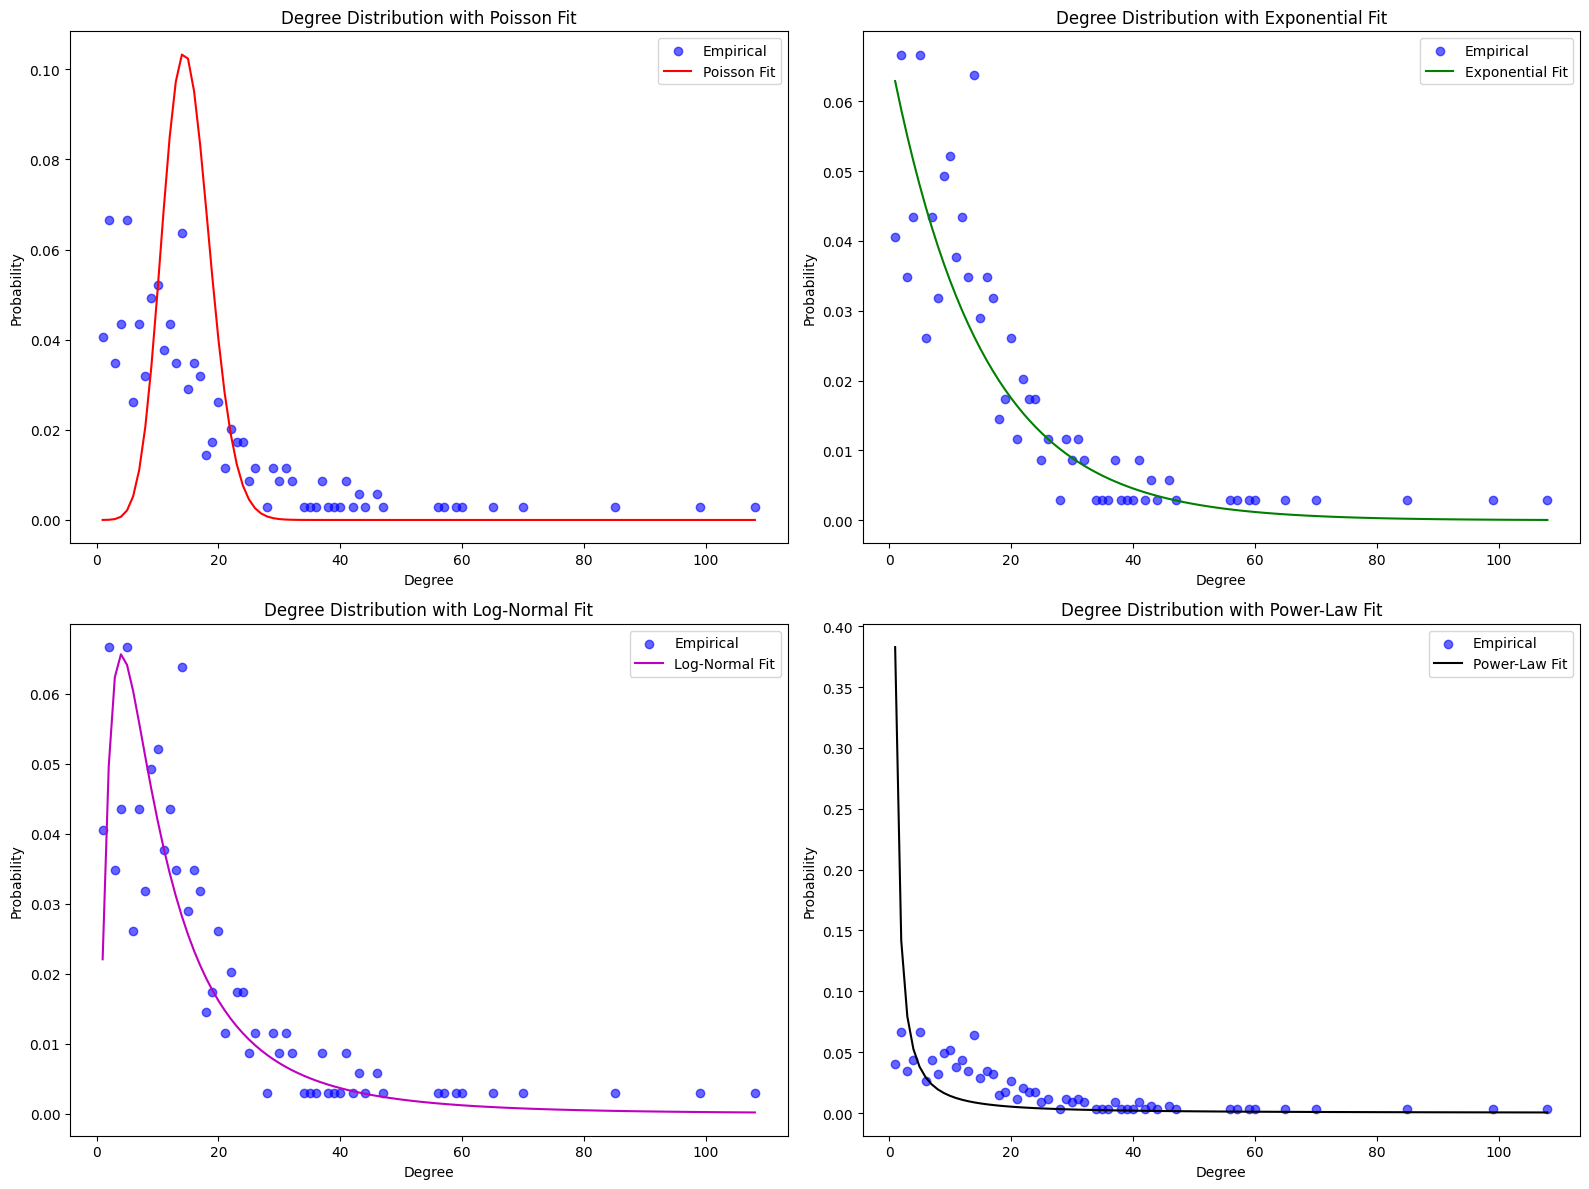

In [254]:
def plot_all_models_linear(degrees, fitted_models):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    models = ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']
    colors = ['r', 'g', 'm', 'k']
    
    for ax, model, color in zip(axes.flatten(), models, colors):
        # Empirical degree distribution
        degree_counts = np.bincount(degrees)
        degrees_unique = np.nonzero(degree_counts)[0]
        counts = degree_counts[degrees_unique]
        prob = counts / counts.sum()
        
        ax.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
        
        # Generate degrees for plotting fitted model
        x = np.arange(degrees_unique.min(), degrees_unique.max() + 1)
        
        if model == 'Poisson':
            pmf = poisson.pmf(x, fitted_models['Poisson']['lambda'])
            ax.plot(x, pmf, color=color, linestyle='-', label='Poisson Fit')
        elif model == 'Exponential':
            pdf = expon.pdf(x, scale=fitted_models['Exponential']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Exponential Fit')
        elif model == 'Log-Normal':
            pdf = lognorm.pdf(x, fitted_models['Log-Normal']['sigma'], loc=fitted_models['Log-Normal']['loc'], scale=fitted_models['Log-Normal']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Log-Normal Fit')
        elif model == 'Power-Law':
            pdf = (x ** (-fitted_models['Power-Law']['alpha']))
            pdf = pdf / pdf.sum()
            ax.plot(x[x >= fitted_models['Power-Law']['xmin']], pdf[x >= fitted_models['Power-Law']['xmin']], color=color, linestyle='-', label='Power-Law Fit')
        
        ax.set_xlabel('Degree')
        ax.set_ylabel('Probability')
        ax.set_title(f'Degree Distribution with {model} Fit')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Call the new function
plot_all_models_linear(degrees, fitted_models)

### Nodes analysis (like centrality)

In [255]:
# Get degrees for nodes in the filtered graph (S_tradition)
degree_dict_traditions = dict(S_tradition.degree())

# Combine node names and degrees
degree_data_traditions = [
    {'node': node, 'degree': degree} for node, degree in degree_dict_traditions.items()
]

# Sort nodes by degree in descending order
degree_data_traditions = sorted(degree_data_traditions, key=lambda x: x['degree'], reverse=True)

# Separate data for plotting
nodes_traditions = [entry['node'] for entry in degree_data_traditions]
degrees_traditions = [entry['degree'] for entry in degree_data_traditions]

# Create an interactive bar plot using Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=list(range(len(nodes_traditions))),
            y=degrees_traditions,
            marker_color='blue',  # All bars in blue
            text=nodes_traditions,  # Hover text
            hovertemplate="<b>Node:</b> %{text}<br><b>Degree:</b> %{y}<extra></extra>",
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Node Degrees in Filtered Graph (S_tradition)",
    xaxis_title="Nodes (sorted by degree)",
    yaxis_title="Degree",
    hovermode="x",
    plot_bgcolor="white",
)

fig.show()

In [256]:
# Print top 30 highest centrality nodes
sorted_centrality = sorted(nx.degree_centrality(S_tradition).items(), key=lambda x: x[1], reverse=True)
print("\nTop 30 nodes by degree centrality:")
for node, centrality in sorted_centrality[:30]:
    print(f"Node: {node}, Degree Centrality: {centrality:.4f}")


Top 30 nodes by degree centrality:
Node: Aristotle, Degree Centrality: 0.3140
Node: Plato, Degree Centrality: 0.2878
Node: Immanuel_Kant, Degree Centrality: 0.2471
Node: Friedrich_Nietzsche, Degree Centrality: 0.2035
Node: Karl_Marx, Degree Centrality: 0.1890
Node: David_Hume, Degree Centrality: 0.1744
Node: Martin_Heidegger, Degree Centrality: 0.1715
Node: Heraclitus, Degree Centrality: 0.1657
Node: René_Descartes, Degree Centrality: 0.1628
Node: Edmund_Husserl, Degree Centrality: 0.1366
Node: Bertrand_Russell, Degree Centrality: 0.1337
Node: John_Locke, Degree Centrality: 0.1337
Node: Michel_Foucault, Degree Centrality: 0.1279
Node: Ludwig_Wittgenstein, Degree Centrality: 0.1250
Node: Jacques_Derrida, Degree Centrality: 0.1250
Node: Socrates, Degree Centrality: 0.1221
Node: Cicero, Degree Centrality: 0.1192
Node: Voltaire, Degree Centrality: 0.1192
Node: Sigmund_Freud, Degree Centrality: 0.1192
Node: Henri_Bergson, Degree Centrality: 0.1163
Node: Thomas_Aquinas, Degree Centrality: 0

In [257]:
import plotly.express as px
import pandas as pd

def plot_centrality_comparison(graph, centrality_x, centrality_y, x_label, y_label, title):
    """
    Creates an interactive scatter plot to compare two centrality measures.

    Parameters:
    - graph: NetworkX graph
    - centrality_x: Dictionary of centrality values for x-axis
    - centrality_y: Dictionary of centrality values for y-axis
    - x_label: Label for x-axis
    - y_label: Label for y-axis
    - title: Title of the plot
    """
    # Prepare data for the plot
    data = pd.DataFrame({
        'Node': list(centrality_x.keys()),
        x_label: list(centrality_x.values()),
        y_label: list(centrality_y.values())
    })

    # Create an interactive scatter plot
    fig = px.scatter(
        data,
        x=x_label,
        y=y_label,
        hover_name='Node',  # Display node name on hover
        hover_data={
            x_label: ':.4f',  # Format centrality values
            y_label: ':.4f'
        },
        title=title,
        labels={x_label: x_label, y_label: y_label},
        template="plotly_white"
    )
    
    fig.show()

# Compute centrality measures
degree_centrality = nx.degree_centrality(S_tradition)
page_rank = nx.pagerank(S_tradition)
betweenness_centrality = nx.betweenness_centrality(S_tradition)
closeness_centrality = nx.closeness_centrality(S_tradition)
eigenvector_centrality = nx.eigenvector_centrality(S_tradition)
clustering = nx.clustering(S_tradition)

# Plot comparisons
plot_centrality_comparison(S_tradition, degree_centrality, page_rank, 
                           "Degree Centrality", "PageRank", 
                           "Degree Centrality vs PageRank")

plot_centrality_comparison(S_tradition, degree_centrality, betweenness_centrality, 
                           "Degree Centrality", "Betweenness Centrality", 
                           "Degree Centrality vs Betweenness Centrality")

plot_centrality_comparison(S_tradition, degree_centrality, closeness_centrality, 
                           "Degree Centrality", "Closeness Centrality", 
                           "Degree Centrality vs Closeness Centrality")

plot_centrality_comparison(S_tradition, degree_centrality, eigenvector_centrality, 
                           "Degree Centrality", "Eigenvector Centrality", 
                           "Degree Centrality vs Eigenvector Centrality")

plot_centrality_comparison(S_tradition, degree_centrality, clustering, 
                           "Degree Centrality", "Clustering Coefficient", 
                           "Degree Centrality vs Clustering Coefficient")



### Graph of the entire network

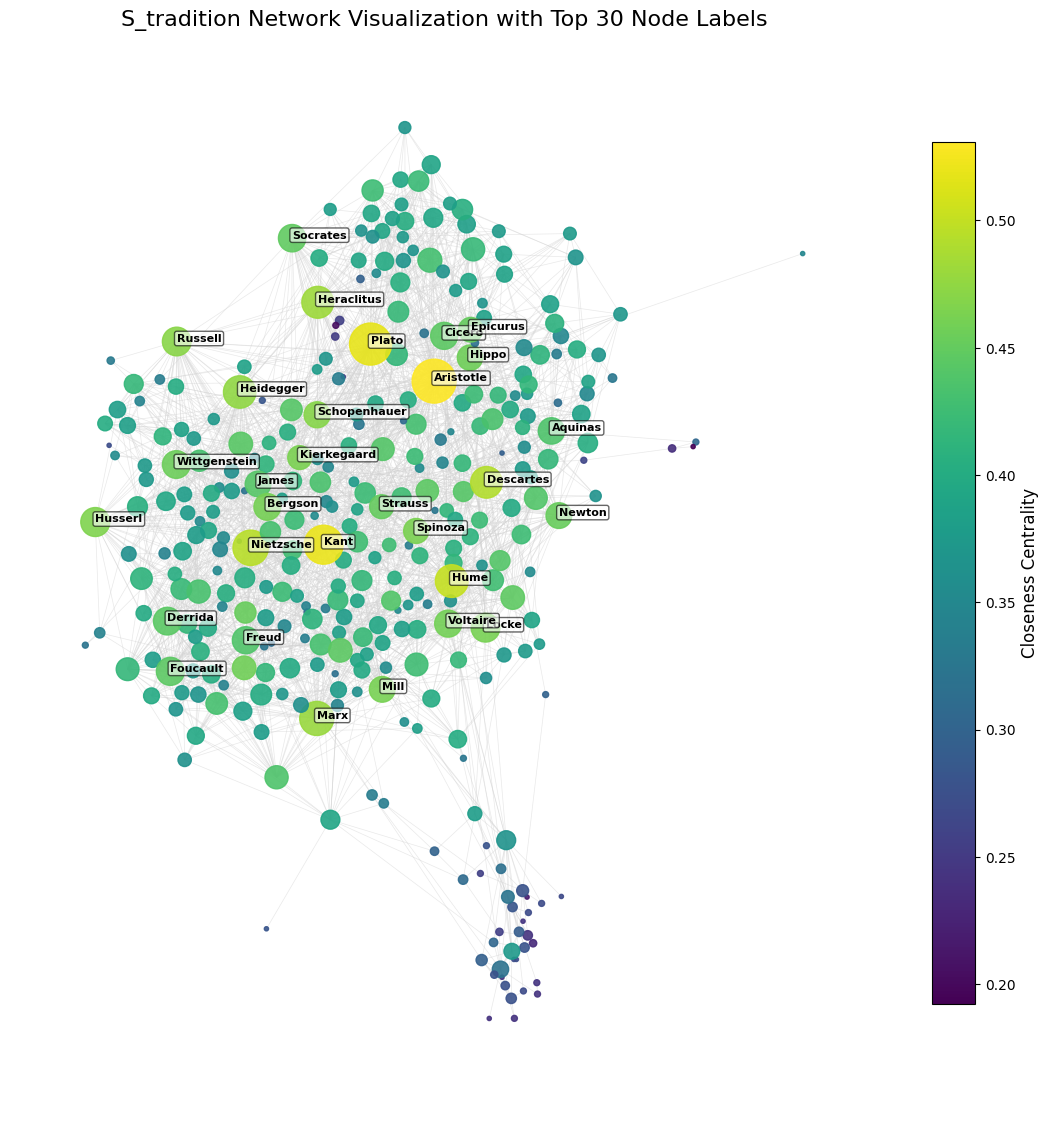

In [258]:
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Calculate centrality measures
degree_centrality = nx.degree_centrality(S_tradition)
closeness_centrality = nx.closeness_centrality(S_tradition)

# Normalize degree centrality for node sizes
max_degree = max(degree_centrality.values())
node_sizes = [1000 * (dc / max_degree) for dc in degree_centrality.values()]

# Normalize closeness centrality for node colors
closeness_values = np.array(list(closeness_centrality.values()))
min_closeness, max_closeness = closeness_values.min(), closeness_values.max()
normalized_colors = (closeness_values - min_closeness) / (max_closeness - min_closeness)

# Color map for nodes based on closeness centrality
cmap = plt.cm.viridis
node_colors = [cmap(value) for value in normalized_colors]

# Sort nodes by degree centrality to find the top 30
top_30_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Initialize and apply ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    edgeWeightInfluence=1.0,
    jitterTolerance=0.05,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=0.1,
    strongGravityMode=False,
    gravity=0.1,
    verbose=False
)

# Compute positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(S_tradition, pos=None, iterations=2000)

# Plot the network
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(
    S_tradition, 
    positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.9
)
nx.draw_networkx_edges(
    S_tradition, 
    positions, 
    edge_color='lightgray', 
    alpha=0.5, 
    width=0.5
)

# Add labels for the top 30 nodes (last names or full names)
for node in top_30_nodes:
    last_name = node.split('_')[-1]  # Take the last part of the name after the '_'
    x, y = positions[node]
    plt.text(
        x, y, 
        last_name, 
        fontsize=8, 
        fontweight='bold', 
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Adding color bar for closeness centrality
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_closeness, vmax=max_closeness))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8)
cbar.set_label('Closeness Centrality', fontsize=12)

# Add title and turn off axis
plt.title("S_tradition Network Visualization with Top 30 Node Labels", fontsize=16)
plt.axis('off')
plt.show()




In [259]:
# Sort nodes by degree centrality in descending order
top_20_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:20]

# Print the traditions for the top 20 nodes
print("traditions of the Top 20 Nodes by Degree Centrality:")
for i, node in enumerate(top_20_nodes, start=1):
    traditions = S_tradition.nodes[node].get('tradition', [])
    print(f"{i}. {node}: {', '.join(traditions)}")

traditions of the Top 20 Nodes by Degree Centrality:
1. Aristotle: Western philosophers
2. Plato: Western philosophers
3. Immanuel_Kant: Western philosophers
4. Friedrich_Nietzsche: Western philosophers
5. Karl_Marx: Western philosophers
6. David_Hume: Western philosophers
7. Martin_Heidegger: Western philosophers
8. Heraclitus: Western philosophers
9. René_Descartes: Western philosophers
10. Edmund_Husserl: Western philosophers
11. Bertrand_Russell: Western philosophers
12. John_Locke: Western philosophers
13. Michel_Foucault: Western philosophers
14. Ludwig_Wittgenstein: Western philosophers
15. Jacques_Derrida: Western philosophers
16. Socrates: Western philosophers
17. Cicero: Western philosophers
18. Voltaire: Western philosophers
19. Sigmund_Freud: Western philosophers
20. Henri_Bergson: Western philosophers


### Plot east-west divide

In [260]:
import requests

def get_total_pageviews(article_name, language='en'):
    """
    Fetch total page views for a Wikipedia article.

    :param article_name: Wikipedia article title (e.g., "Wang_Yangming").
    :param language: Language of Wikipedia (default: 'en').
    :return: Total page views or None if the article does not exist.
    """
    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{language}.wikipedia/all-access/user/{article_name}/monthly/20150701/20241231"
    headers = {
        "User-Agent": "YourAppName/1.0 (your.email@example.com)"
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error fetching data for {article_name}: {response.status_code}")
        return None
    
    data = response.json()
    total_views = sum(item['views'] for item in data.get('items', []))
    return total_views

In [261]:
# # Add page views as a node attribute in the filtered graph
# for node in S_tradition.nodes():
#     # Replace spaces with underscores to match Wikipedia article format
#     article_name = node.replace(" ", "_")
#     total_views = get_total_pageviews(article_name)
#     S_tradition.nodes[node]['pageviews'] = total_views if total_views is not None else 0
#     print(f"Node: {node}, Pageviews: {total_views}")

In [262]:
# # save the graph with pageviews
# pickle.dump(S_tradition, open("pickle_files/tradition_graph_with_pageviews.pkl", "wb"))

In [263]:
# Load the graph with pageviews
S_tradition = pickle.load(open("pickle_files/tradition_graph_with_pageviews.pkl", "rb"))

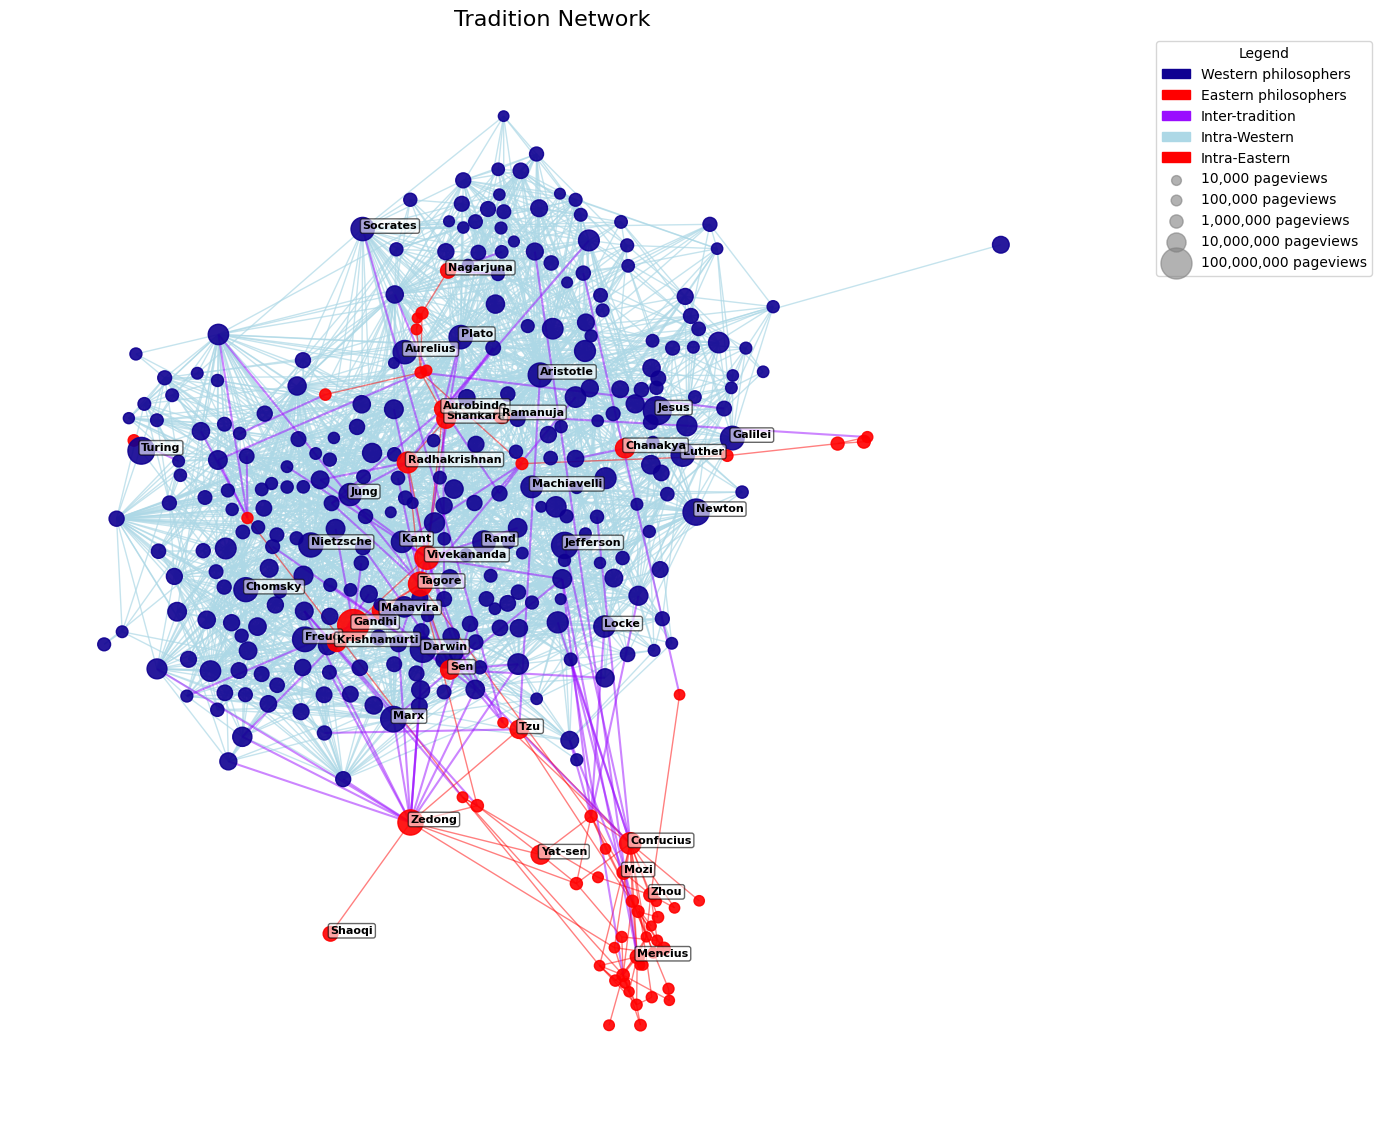

In [264]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define custom colors for the traditions and intra-tradition edges
color_map = {
    "Western philosophers": "#0f0091",  # Dark blue for nodes
    "Eastern philosophers": "red"       # Red for nodes
}
intra_edge_colors = {
    "Western philosophers": "lightblue",  # Light blue for intra-Western edges
    "Eastern philosophers": "red"       # Light pink for intra-Eastern edges
}

# Assign colors to nodes based on their tradition
node_colors = [
    color_map[S_tradition.nodes[node]['tradition'][0]]  # Use the first element if 'tradition' is a list
    if isinstance(S_tradition.nodes[node]['tradition'], list)
    else color_map[S_tradition.nodes[node]['tradition']]
    for node in S_tradition.nodes()
]

# Separate edges into inter-tradition (purple) and intra-tradition (light blue/pink)
inter_tradition_edges = []
intra_west_edges = []
intra_east_edges = []

for u, v in S_tradition.edges():
    u_tradition = S_tradition.nodes[u]['tradition'][0] if isinstance(S_tradition.nodes[u]['tradition'], list) else S_tradition.nodes[u]['tradition']
    v_tradition = S_tradition.nodes[v]['tradition'][0] if isinstance(S_tradition.nodes[v]['tradition'], list) else S_tradition.nodes[v]['tradition']
    
    if u_tradition != v_tradition:
        inter_tradition_edges.append((u, v))
    elif u_tradition == "Western philosophers":
        intra_west_edges.append((u, v))
    elif u_tradition == "Eastern philosophers":
        intra_east_edges.append((u, v))

# Get pageviews and avoid zeroes
pageviews = nx.get_node_attributes(S_tradition, 'pageviews')
values = [max(pv, 1) for pv in pageviews.values()]

# Custom scaling function
def scale_pageviews(pageviews, min_size=50, max_size=500):
    min_pv = np.min(pageviews)
    max_pv = np.max(pageviews)
    transformed = np.sqrt(pageviews)  
    scaled = min_size + (transformed - np.sqrt(min_pv)) / (np.sqrt(max_pv) - np.sqrt(min_pv)) * (max_size - min_size)
    return scaled

# Calculate node sizes using the custom scaling
node_sizes = scale_pageviews(np.array(values))

# Identify top 20 nodes by pageviews in each tradition
western_top_nodes = sorted(
    [node for node in S_tradition.nodes() if S_tradition.nodes[node]['tradition'][0] == 'Western philosophers'], 
    key=lambda x: pageviews[x], 
    reverse=True
)[:20]

eastern_top_nodes = sorted(
    [node for node in S_tradition.nodes() if S_tradition.nodes[node]['tradition'][0] == 'Eastern philosophers'], 
    key=lambda x: pageviews[x], 
    reverse=True
)[:20]

# Plot the network
plt.figure(figsize=(14, 14))

# Draw nodes with scaled sizes
nx.draw_networkx_nodes(
    S_tradition, 
    positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.9
)

# Draw intra-tradition edges
nx.draw_networkx_edges(
    S_tradition, 
    positions, 
    edgelist=intra_west_edges, 
    edge_color=intra_edge_colors["Western philosophers"], 
    alpha=0.7, 
    width=1.0
)
nx.draw_networkx_edges(
    S_tradition, 
    positions, 
    edgelist=intra_east_edges, 
    edge_color=intra_edge_colors["Eastern philosophers"], 
    alpha=0.5, 
    width=1.0
)

# Draw inter-tradition edges (purple)
nx.draw_networkx_edges(
    S_tradition, 
    positions, 
    edgelist=inter_tradition_edges, 
    edge_color='#9a0dff', 
    alpha=0.5, 
    width=1.5
)

# Add labels for the top 20 nodes in each tradition (last name only)
for node in western_top_nodes + eastern_top_nodes:
    last_name = node.split('_')[-1]  # Extract the last name from the node name
    x, y = positions[node]
    plt.text(
        x, y, 
        last_name, 
        fontsize=8, 
        fontweight='bold', 
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Add tradition and edge color legend
color_legend_handles = [
    mpatches.Patch(color=color, label=tradition)
    for tradition, color in color_map.items()
]
color_legend_handles.extend([
    mpatches.Patch(color='#9a0dff', label='Inter-tradition'),
    mpatches.Patch(color='lightblue', label='Intra-Western'),
    mpatches.Patch(color='red', label='Intra-Eastern')
])

# Add node size legend (rounded to powers of 10)
min_pv, max_pv = min(values), max(values)
legend_values = np.logspace(np.floor(np.log10(min_pv)), np.ceil(np.log10(max_pv)), num=5, base=10)  # Powers of 10
legend_sizes = scale_pageviews(legend_values)

size_legend_handles = [
    plt.scatter([], [], s=size, color='gray', alpha=0.6, label=f"{int(value):,d} pageviews")
    for size, value in zip(legend_sizes, legend_values)
]

# Combine both legends
plt.legend(
    handles=color_legend_handles + size_legend_handles,
    title="Legend",
    loc="best",
    bbox_to_anchor=(1.05, 1),
    fontsize=10
)

# Add title and turn off axis
plt.title("Tradition Network", fontsize=16)
plt.axis('off')
plt.show()


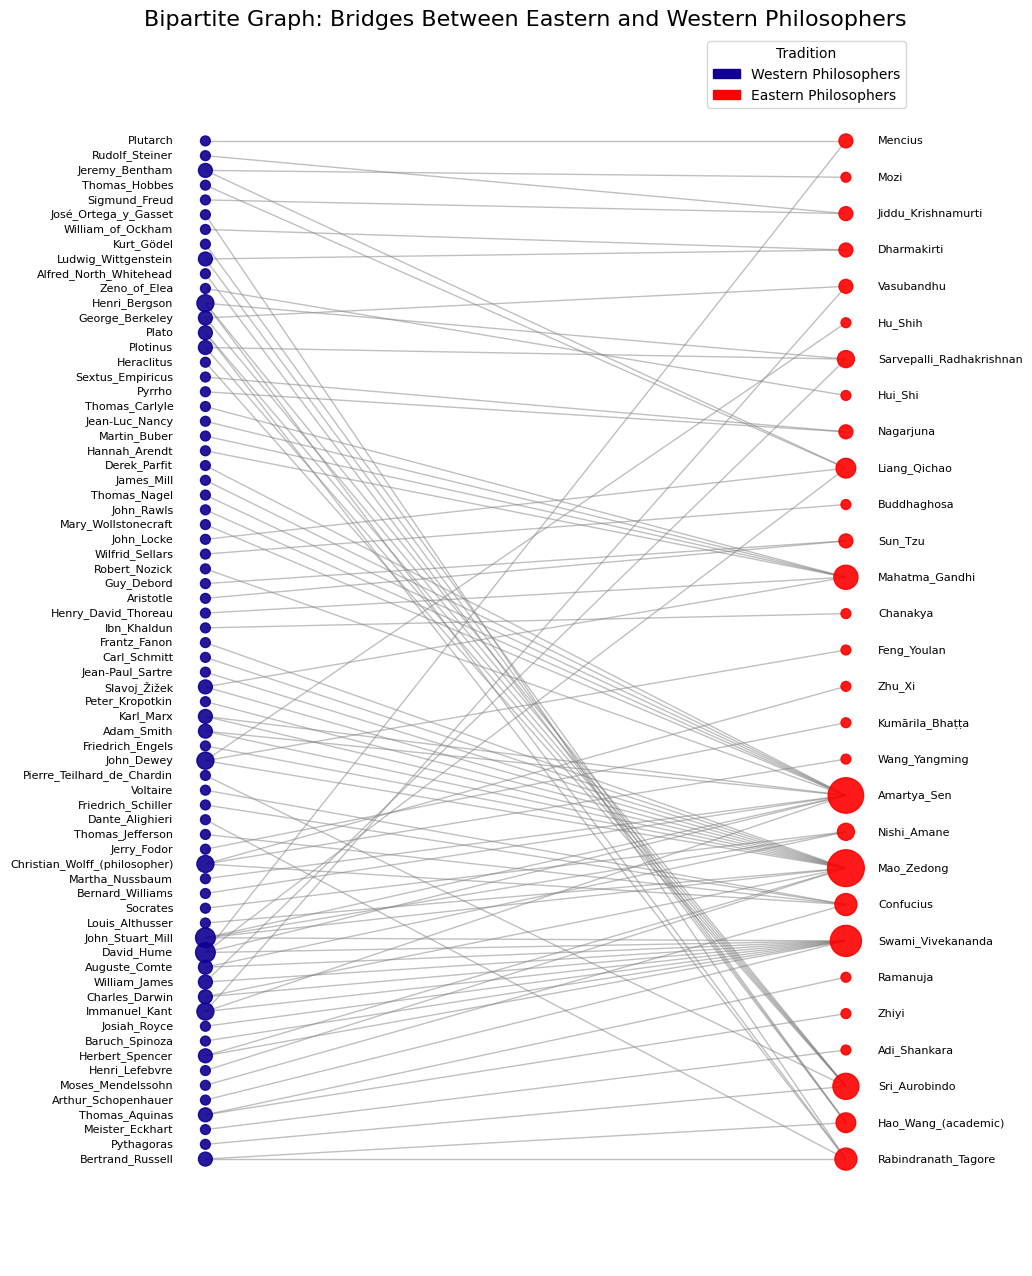

Number of nodes in the bipartite graph:
Western philosophers: 70
Eastern philosophers: 29


In [217]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Step 1: Define traditions
traditions = nx.get_node_attributes(S_tradition, 'tradition')

# Step 2: Identify bridges
bridge_counts = defaultdict(int)
for u, v in S_tradition.edges():
    u_tradition = traditions[u][0] if isinstance(traditions[u], list) else traditions[u]
    v_tradition = traditions[v][0] if isinstance(traditions[v], list) else traditions[v]
    
    # Check if the edge is a bridge between traditions
    if u_tradition != v_tradition:
        bridge_counts[u] += 1
        bridge_counts[v] += 1

# Step 3: Filter nodes to include only those involved in bridges
nodes_with_bridges = {node for node, count in bridge_counts.items() if count > 0}

# Step 4: Create a bipartite graph with only bridge nodes and edges
B = nx.Graph()
for u, v in S_tradition.edges():
    if u in nodes_with_bridges and v in nodes_with_bridges:
        u_tradition = traditions[u][0] if isinstance(traditions[u], list) else traditions[u]
        v_tradition = traditions[v][0] if isinstance(traditions[v], list) else traditions[v]
        if u_tradition != v_tradition:
            B.add_node(u, tradition=u_tradition, size=bridge_counts[u])
            B.add_node(v, tradition=v_tradition, size=bridge_counts[v])
            B.add_edge(u, v)

# Step 5: Separate nodes by tradition
western_nodes = [n for n, d in B.nodes(data=True) if d['tradition'] == "Western philosophers"]
eastern_nodes = [n for n, d in B.nodes(data=True) if d['tradition'] == "Eastern philosophers"]

# Step 6: Define positions for bipartite layout
max_nodes = max(len(western_nodes), len(eastern_nodes))
western_y = np.linspace(-max_nodes, max_nodes, len(western_nodes))
eastern_y = np.linspace(-max_nodes, max_nodes, len(eastern_nodes))

positions = {}
positions.update({node: (0, y) for node, y in zip(western_nodes, western_y)})  # Western on the left
positions.update({node: (1, y) for node, y in zip(eastern_nodes, eastern_y)})  # Eastern on the right

# Step 7: Draw the bipartite graph
plt.figure(figsize=(10, 16))

# Draw nodes
node_sizes = [50 * B.nodes[node]['size'] for node in B.nodes()]
node_colors = ['#0f0091' if node in western_nodes else 'red' for node in B.nodes()]
nx.draw_networkx_nodes(B, positions, node_size=node_sizes, node_color=node_colors, alpha=0.9)

# Draw edges
nx.draw_networkx_edges(B, positions, edge_color="gray", alpha=0.5, width=1.0)

# Add labels for nodes
for node in B.nodes():
    x, y = positions[node]
    if node in western_nodes:
        plt.text(
            x - 0.05, y, node, fontsize=8, horizontalalignment='right', verticalalignment='center'
        )
    else:
        plt.text(
            x + 0.05, y, node, fontsize=8, horizontalalignment='left', verticalalignment='center'
        )

# Add legend
western_patch = mpatches.Patch(color='#0f0091', label='Western Philosophers')
eastern_patch = mpatches.Patch(color='red', label='Eastern Philosophers')
plt.legend(handles=[western_patch, eastern_patch], loc="upper right", title="Tradition")

# Title and axis
plt.title("Bipartite Graph: Bridges Between Eastern and Western Philosophers", fontsize=16)
plt.axis('off')
plt.show()

# Step 8: Print the number of nodes in each tradition
print("Number of nodes in the bipartite graph:")
print(f"Western philosophers: {len(western_nodes)}")
print(f"Eastern philosophers: {len(eastern_nodes)}")


## Community specific metrics

#### Wetsern Subgraph

In [218]:
# create a S_western graph by removing any node that has 'tradition': ['Eastern philosophers'] attribute
S_western = S_tradition.copy()
for node in list(S_tradition.nodes):
    if 'Eastern philosophers' in S_tradition.nodes[node].get('tradition', []):
        S_western.remove_node(node)

# print the number of nodes and edges in the S_western graph
print("Number of nodes in S_western: ", S_western.number_of_nodes())
print("Number of edges in S_western: ", S_western.number_of_edges())

Number of nodes in S_western:  278
Number of edges in S_western:  2354


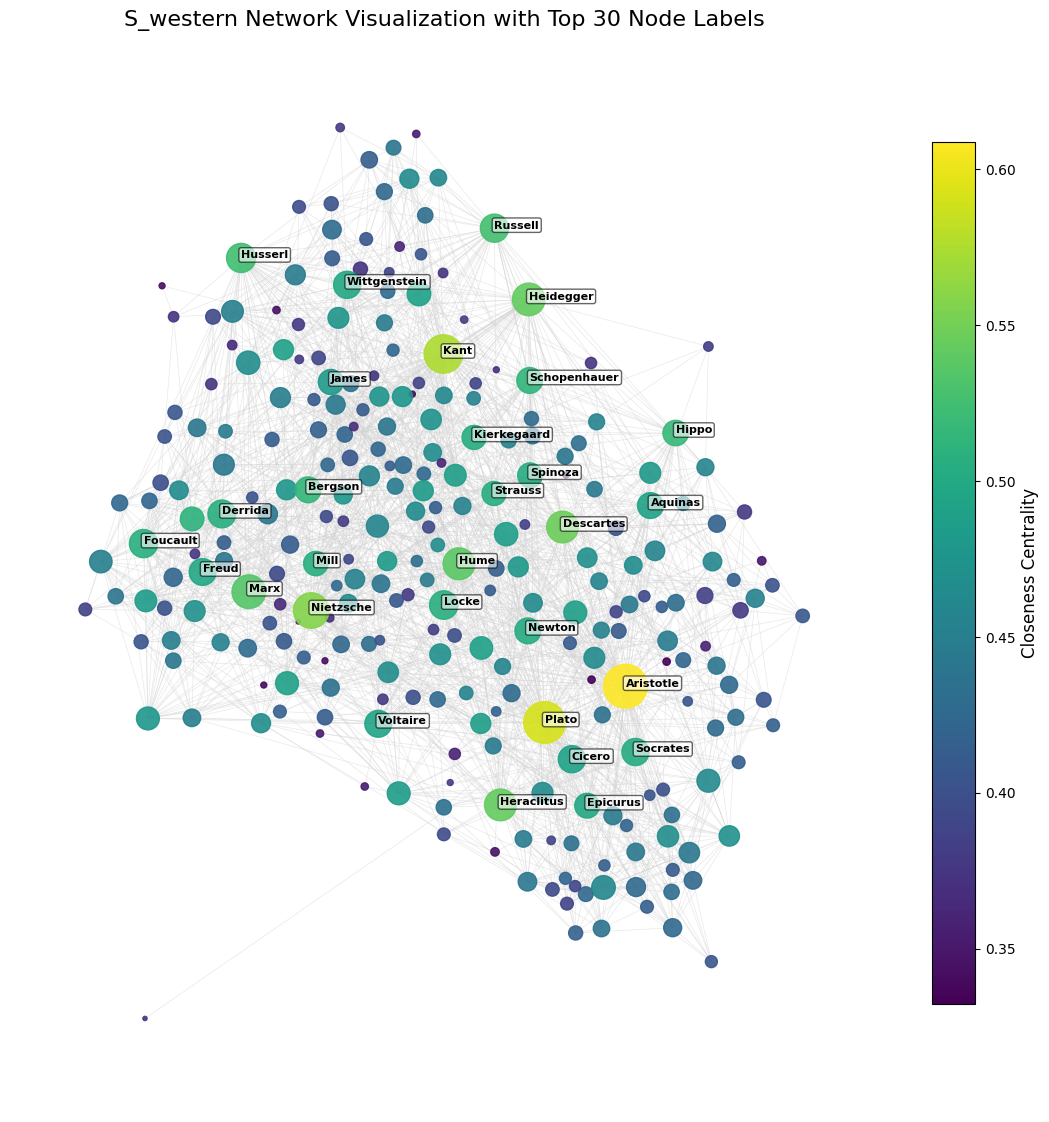

In [219]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(S_western)
closeness_centrality = nx.closeness_centrality(S_western)

# Normalize degree centrality for node sizes
max_degree = max(degree_centrality.values())
node_sizes = [1000 * (dc / max_degree) for dc in degree_centrality.values()]

# Normalize closeness centrality for node colors
closeness_values = np.array(list(closeness_centrality.values()))
min_closeness, max_closeness = closeness_values.min(), closeness_values.max()
normalized_colors = (closeness_values - min_closeness) / (max_closeness - min_closeness)

# Color map for nodes based on closeness centrality
cmap = plt.cm.viridis
node_colors = [cmap(value) for value in normalized_colors]

# Sort nodes by degree centrality to find the top 30
top_30_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Initialize and apply ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    edgeWeightInfluence=1.0,
    jitterTolerance=0.05,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=0.1,
    strongGravityMode=False,
    gravity=0.1,
    verbose=False
)

# Compute positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(S_western, pos=None, iterations=2000)

# Plot the network
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(
    S_western, 
    positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.9
)
nx.draw_networkx_edges(
    S_western, 
    positions, 
    edge_color='lightgray', 
    alpha=0.5, 
    width=0.5
)

# Add labels for the top 30 nodes (last names or full names)
for node in top_30_nodes:
    last_name = node.split('_')[-1]  # Take the last part of the name after the '_'
    x, y = positions[node]
    plt.text(
        x, y, 
        last_name, 
        fontsize=8, 
        fontweight='bold', 
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Adding color bar for closeness centrality
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_closeness, vmax=max_closeness))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8)
cbar.set_label('Closeness Centrality', fontsize=12)

# Add title and turn off axis
plt.title("S_western Network Visualization with Top 30 Node Labels", fontsize=16)
plt.axis('off')
plt.show()

In [220]:
# print all metrics of the graph (centrality, density, diameter, etc.)
# Function to compute centrality measures
def compute_centrality_measures(subgraph):
    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    eigenvector_centrality = nx.eigenvector_centrality(subgraph)
    page_rank = nx.pagerank(subgraph)
    clustering = nx.clustering(subgraph)
    return {
        "degree": degree_centrality,
        "closeness": closeness_centrality,
        "betweenness": betweenness_centrality,
        "eigenvector": eigenvector_centrality,
        "pagerank": page_rank,
        "clustering": clustering
    }


# Function to find the top nodes by each centrality measure
def get_top_nodes_by_centrality(centrality_measures, top_n=10):
    top_nodes = {}
    for measure_name, centrality_dict in centrality_measures.items():
        sorted_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_nodes[measure_name] = sorted_nodes
    return top_nodes

# Compute centrality measures for S_western
centrality_measures_western = compute_centrality_measures(S_western)

# Get the top 10 nodes by each centrality measure
top_nodes_western = get_top_nodes_by_centrality(centrality_measures_western)

# Print the top nodes by each centrality measure
print("\nTop 10 nodes by centrality measures in S_western:")
for measure, nodes in top_nodes_western.items():
    print(f"\n{measure.capitalize()} Centrality:")
    for node, centrality in nodes:
        print(f"Node: {node}, Centrality: {centrality:.4f}")



Top 10 nodes by centrality measures in S_western:

Degree Centrality:
Node: Aristotle, Centrality: 0.3863
Node: Plato, Centrality: 0.3502
Node: Immanuel_Kant, Centrality: 0.2960
Node: Friedrich_Nietzsche, Centrality: 0.2527
Node: Karl_Marx, Centrality: 0.2274
Node: Martin_Heidegger, Centrality: 0.2130
Node: Heraclitus, Centrality: 0.2022
Node: René_Descartes, Centrality: 0.2022
Node: David_Hume, Centrality: 0.2022
Node: Edmund_Husserl, Centrality: 0.1697

Closeness Centrality:
Node: Aristotle, Centrality: 0.6088
Node: Plato, Centrality: 0.5906
Node: Immanuel_Kant, Centrality: 0.5747
Node: Friedrich_Nietzsche, Centrality: 0.5573
Node: René_Descartes, Centrality: 0.5464
Node: Martin_Heidegger, Centrality: 0.5421
Node: Heraclitus, Centrality: 0.5421
Node: David_Hume, Centrality: 0.5379
Node: Karl_Marx, Centrality: 0.5347
Node: Bertrand_Russell, Centrality: 0.5256

Betweenness Centrality:
Node: Aristotle, Centrality: 0.1359
Node: Plato, Centrality: 0.0926
Node: Immanuel_Kant, Centrality: 

In [221]:
# plot the centrality comparison
plot_centrality_comparison(S_western, centrality_measures_western['degree'], centrality_measures_western['closeness'], 
                           "Degree Centrality", "Closeness Centrality", 
                           "Degree Centrality vs Closeness Centrality")

plot_centrality_comparison(S_western, centrality_measures_western['degree'], centrality_measures_western['betweenness'],
                            "Degree Centrality", "Betweenness Centrality", 
                            "Degree Centrality vs Betweenness Centrality")


plot_centrality_comparison(S_western, centrality_measures_western['degree'], centrality_measures_western['eigenvector'],
                            "Degree Centrality", "Eigenvector Centrality", 
                            "Degree Centrality vs Eigenvector Centrality")

plot_centrality_comparison(S_western, centrality_measures_western['degree'], centrality_measures_western['pagerank'],
                            "Degree Centrality", "PageRank", 
                            "Degree Centrality vs PageRank")

plot_centrality_comparison(S_western, centrality_measures_western['degree'], centrality_measures_western['clustering'],
                            "Degree Centrality", "Clustering Coefficient", 
                            "Degree Centrality vs Clustering Coefficient")


#### Eastern Subgraph

In [222]:
# Get S_eastern graph by removing any node that has 'tradition': ['Western philosophers'] attribute
S_eastern = S_tradition.copy()
for node in list(S_tradition.nodes):
    if 'Western philosophers' in S_tradition.nodes[node].get('tradition', []):
        S_eastern.remove_node(node)

# Print the number of nodes and edges in the S_eastern graph
print("Number of nodes in S_eastern: ", S_eastern.number_of_nodes())
print("Number of edges in S_eastern: ", S_eastern.number_of_edges())

Number of nodes in S_eastern:  67
Number of edges in S_eastern:  113


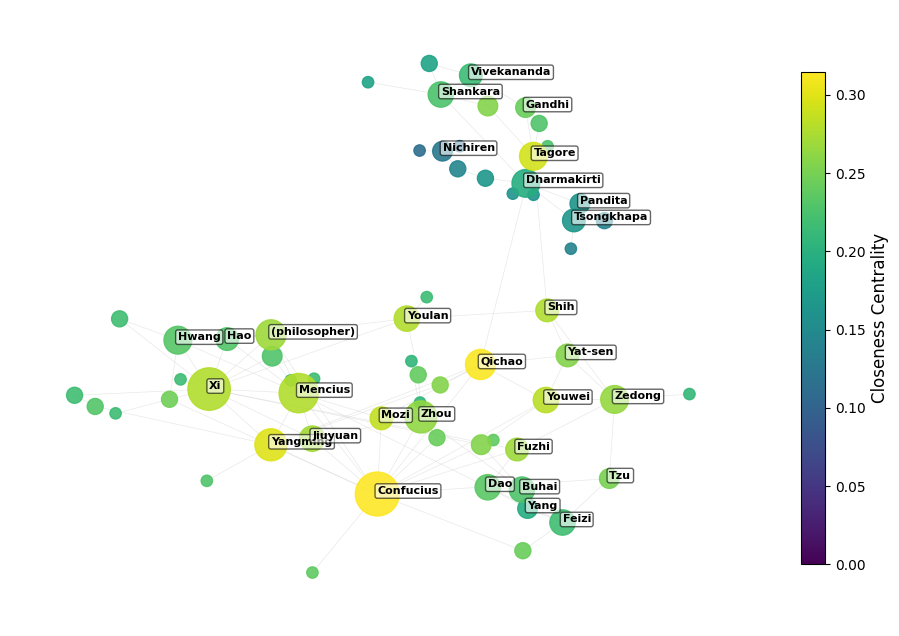

In [270]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(S_eastern)
closeness_centrality = nx.closeness_centrality(S_eastern)

# Normalize degree centrality for node sizes
max_degree = max(degree_centrality.values())
node_sizes = [1000 * (dc / max_degree) for dc in degree_centrality.values()]

# Normalize closeness centrality for node colors
closeness_values = np.array(list(closeness_centrality.values()))
min_closeness, max_closeness = closeness_values.min(), closeness_values.max()
normalized_colors = (closeness_values - min_closeness) / (max_closeness - min_closeness)

# Color map for nodes based on closeness centrality
cmap = plt.cm.viridis
node_colors = [cmap(value) for value in normalized_colors]

# Sort nodes by degree centrality to find the top 30
top_30_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Initialize and apply ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    edgeWeightInfluence=1.0,
    jitterTolerance=0.05,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=0.1,
    strongGravityMode=False,
    gravity=0.1,
    verbose=False
)

# Compute positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(S_eastern, pos=None, iterations=2000)

# Plot the network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(
    S_eastern, 
    positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.9
)
nx.draw_networkx_edges(
    S_eastern, 
    positions, 
    edge_color='lightgray', 
    alpha=0.5, 
    width=0.5
)

# Add labels for the top 30 nodes (last names or full names)
for node in top_30_nodes:
    last_name = node.split('_')[-1]  # Take the last part of the name after the '_'
    x, y = positions[node]
    plt.text(
        x, y, 
        last_name, 
        fontsize=8, 
        fontweight='bold', 
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Adding color bar for closeness centrality
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_closeness, vmax=max_closeness))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8)
cbar.set_label('Closeness Centrality', fontsize=12)

# Add title and turn off axis
# plt.title("S_eastern Network Visualization with Top 30 Node Labels", fontsize=16)
plt.axis('off')
plt.show()

In [224]:
# Compute centrality measures for S_eastern
centrality_measures_eastern = compute_centrality_measures(S_eastern)

# Get the top 10 nodes by each centrality measure
top_nodes_eastern = get_top_nodes_by_centrality(centrality_measures_eastern)

# Print the top nodes by each centrality measure
print("\nTop 10 nodes by centrality measures in S_eastern:")
for measure, nodes in top_nodes_eastern.items():
    print(f"\n{measure.capitalize()} Centrality:")
    for node, centrality in nodes:
        print(f"Node: {node}, Centrality: {centrality:.4f}")

# plot the centrality comparison
plot_centrality_comparison(S_eastern, centrality_measures_eastern['degree'], centrality_measures_eastern['closeness'], 
                           "Degree Centrality", "Closeness Centrality", 
                           "Degree Centrality vs Closeness Centrality")

plot_centrality_comparison(S_eastern, centrality_measures_eastern['degree'], centrality_measures_eastern['betweenness'],
                            "Degree Centrality", "Betweenness Centrality", 
                            "Degree Centrality vs Betweenness Centrality")

plot_centrality_comparison(S_eastern, centrality_measures_eastern['degree'], centrality_measures_eastern['eigenvector'],
                            "Degree Centrality", "Eigenvector Centrality", 
                            "Degree Centrality vs Eigenvector Centrality")

plot_centrality_comparison(S_eastern, centrality_measures_eastern['degree'], centrality_measures_eastern['pagerank'],
                            "Degree Centrality", "PageRank", 
                            "Degree Centrality vs PageRank")


Top 10 nodes by centrality measures in S_eastern:

Degree Centrality:
Node: Confucius, Centrality: 0.2273
Node: Zhu_Xi, Centrality: 0.2121
Node: Mencius, Centrality: 0.1818
Node: Wang_Yangming, Centrality: 0.1212
Node: Zhuang_Zhou, Centrality: 0.1212
Node: Liang_Qichao, Centrality: 0.1061
Node: Cheng_Yi_(philosopher), Centrality: 0.1061
Node: Mao_Zedong, Centrality: 0.0909
Node: Yi_Hwang, Centrality: 0.0909
Node: Dharmakirti, Centrality: 0.0909

Closeness Centrality:
Node: Confucius, Centrality: 0.3149
Node: Liang_Qichao, Centrality: 0.3132
Node: Wang_Yangming, Centrality: 0.2992
Node: Rabindranath_Tagore, Centrality: 0.2933
Node: Mozi, Centrality: 0.2864
Node: Kang_Youwei, Centrality: 0.2823
Node: Zhu_Xi, Centrality: 0.2784
Node: Feng_Youlan, Centrality: 0.2784
Node: Mencius, Centrality: 0.2784
Node: Hu_Shih, Centrality: 0.2771

Betweenness Centrality:
Node: Rabindranath_Tagore, Centrality: 0.4155
Node: Sarvepalli_Radhakrishnan, Centrality: 0.3214
Node: Adi_Shankara, Centrality: 0.31